In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [2]:
# gpu = tf.config.list_physical_devices('GPU')
# gpu

In [3]:
df, df_info = tfds.load('cifar10', split='train', with_info=True)

2023-03-10 03:00:42.769851: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


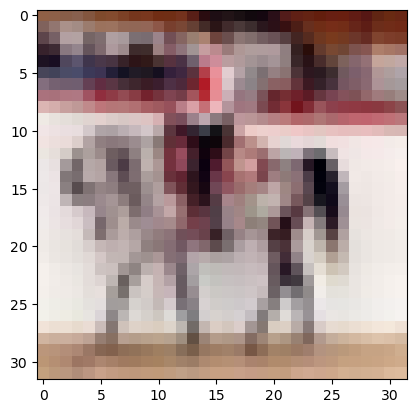

In [4]:
dataiter = df.as_numpy_iterator()
plt.imshow(np.squeeze(dataiter.next()['image']))

In [5]:
dataiter.next()['image'].shape

(32, 32, 3)

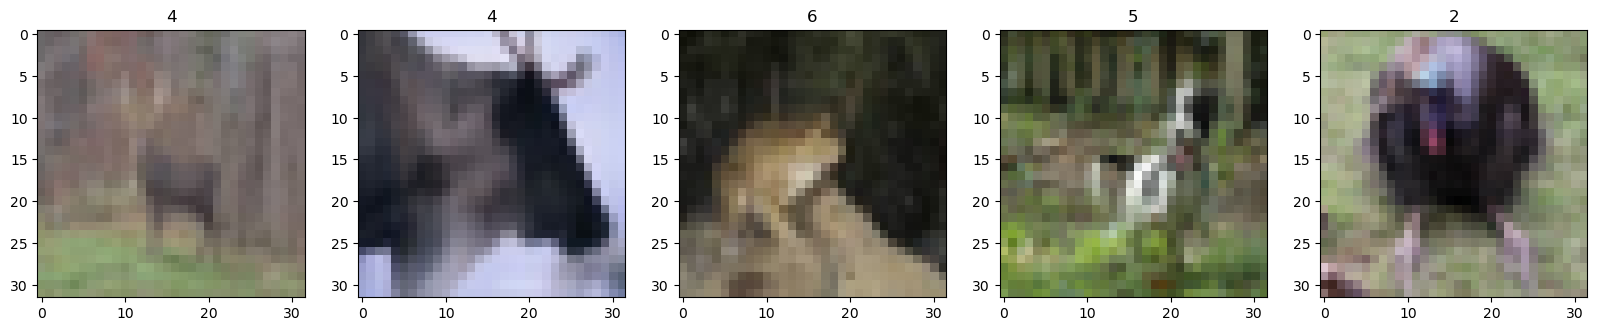

In [6]:
fix, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx in range(5):
  batch = dataiter.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [7]:
def scaleimg(data):
  img = data['image']
  return img/255

In [8]:
df = df.map(scaleimg)
df = df.cache()
df = df.shuffle(60000)
df = df.batch(1024)
df = df.prefetch(64)

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Reshape, Conv2D, UpSampling2D, Dropout, Flatten

In [46]:
def build_generator():
  model = Sequential()
  model.add(Dense(8*8*1024, input_dim=1024))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8,8,1024)))

  #upsampling block-1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsampling block-2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  #Conv layer-1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #Conv layer-2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #Conv layer-3
  model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
  return model

In [47]:
generator = build_generator()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 65536)             67174400  
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 65536)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 1024)        0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 16, 16, 1024)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 128)       3276928   
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                      

In [50]:
#generating 4 random images of 128 size
img = generator.predict(np.random.randn(4,1024))
img.shape

1/1 [==============================] - 0s 101ms/step


(4, 32, 32, 3)

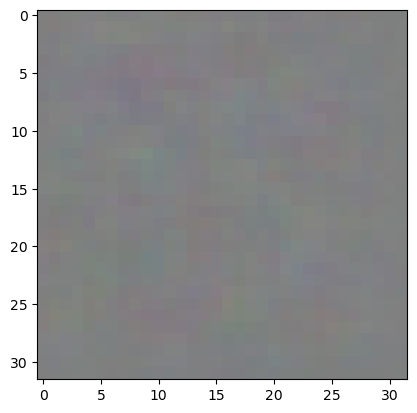

In [51]:
plt.imshow(img[0])

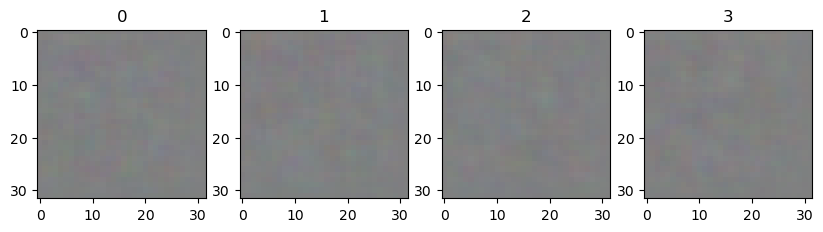

In [52]:
fix, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, i in enumerate(img):
  ax[idx].imshow(i)
  ax[idx].title.set_text(idx)

In [53]:
def build_discriminator():
  model=Sequential()

  #first conv layer
  model.add(Conv2D(32, 5, input_shape=(32, 32, 3)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #second conv layer
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #third conv layer
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #fourth conv layer
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #layer to output T/F
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [54]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 64)        51264     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 24, 24, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 20, 20, 128)      

In [55]:
#passing a batch of images
discriminator.predict(img)

1/1 [==============================] - 0s 51ms/step


array([[0.47621074],
       [0.47616398],
       [0.47594857],
       [0.4761665 ]], dtype=float32)

In [56]:
#passing a single image do this as model expects batch number as first dimention
discriminator.predict(np.expand_dims(img[0], 0))

1/1 [==============================] - 0s 14ms/step


array([[0.47621077]], dtype=float32)

In [57]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [58]:
g_opt = Adam(learning_rate=0.002)
d_opt = Adam(learning_rate=0.0004)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [59]:
#Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [60]:
class GAN(Model):
  #*args - arguments, **kwargs - key-word arguments
  def __init__(self, generator, discriminator, *args, **kwargs):
    #Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    #Creating attributes for generator and discriminator
    self.gen = generator
    self.disc = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    #Compile with base-class
    super().compile(*args, **kwargs)

    #Attribs for optimizers and losses
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real = batch
    fake = self.gen(tf.random.normal((1024, 1024, 1)), training=False)

    #Train the discriminator
    with tf.GradientTape() as d_tape:
      #1. Pass real and fake images to discriminator
      yhat_real = self.disc(real, training=True)
      yhat_fake = self.disc(fake, training=True)
      yhat = tf.concat([yhat_real, yhat_fake], axis=0)

      #2. Create labels for real and fake images
      y = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) #yhat_real values are now 0s and yhat_fake are 1s

      #3. Add noise to the output of discriminator to slow it down
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y += tf.concat([noise_real, noise_fake], axis=0)
      
      #4. Calculate the loss
      total_d_loss = self.d_loss(y, yhat)

    #Backprop to update weights
    d_grad = d_tape.gradient(total_d_loss, self.disc.trainable_variables)
    self.d_opt.apply_gradients(zip(d_grad, self.disc.trainable_variables))

    #train the generator
    with tf.GradientTape() as g_tape:
      #1. Generate some new images
      gen_images = self.gen(tf.random.normal((1024, 1024, 1)), training = True)

      #2. Create predicted labels
      predicted_labels = self.disc(gen_images, training=False)

      #3. Calculate loss
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
    #Apply backprop
    g_grad = g_tape.gradient(total_g_loss, self.gen.trainable_variables)
    self.g_opt.apply_gradients(zip(g_grad, self.gen.trainable_variables))

    return {"d_loss ":total_d_loss, "g_loss ":total_g_loss}

In [61]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [62]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [63]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=1024):
    self.num_img=num_img
    self.latent_dim=latent_dim
  
  def on_epoch_end(self, epochs, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.gen(random_latent_vectors)
    generated_images *=255
    generated_images.numpy()

    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('GAN-Images', f'generated_image_{epochs}_{i}.png'))

In [64]:
hist = gan.fit(df, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
16/49 [========>.....................] - ETA: 26:53 - d_loss : 0.5621 - g_loss : 0.8086

KeyboardInterrupt: 